# PCoE

[PCoE][pcoe]のNo.6(Turbofan)でFD001データセットの可視化ノートブックです。

[pcoe]: https://ti.arc.nasa.gov/c/6/


In [1]:
# default packages
import logging
import pathlib
import zipfile
from typing import Any, Dict, Sequence, Tuple

In [2]:
# third party packages
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import tqdm.autonotebook as tqdm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [3]:
# logger
_logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [4]:
# seaborn
sns.set()

# Global parameters

In [5]:
PATH_ARCHIVE = pathlib.Path("turbofun.zip")
PATH_EXTRACT = pathlib.Path("turbofun")

In [6]:
# 利用する変数を定義
COLUMNS_ALL = [
    *[f"op{i:02}" for i in range(3)],
    *[f"sensor{i:02}" for i in range(26)],
]
COLUMNS_INVALID = [
    "op02",
    "sensor01",
    "sensor04",
    "sensor09",
    "sensor15",
    "sensor17",
    "sensor18",
    "sensor21",
    "sensor22",
    "sensor23",
    "sensor24",
    "sensor25",
]
COLUMNS_VALID = sorted(list(set(COLUMNS_ALL) - set(COLUMNS_INVALID)))

COLUMNS_TARGET = ["rul"]

# Load dataset

In [7]:
def download(filename: pathlib.Path) -> None:
    """zipファイルをダウンロード."""
    if filename.exists():
        return

    url = "https://ti.arc.nasa.gov/c/6/"
    res = requests.get(url, stream=True)
    if res.status_code != 200:
        _logger.error(res.status_code)
        return

    with open(filename, "wb") as f:
        for chunk in tqdm.tqdm(res):
            f.write(chunk)


download(PATH_ARCHIVE)

In [8]:
def extractall(src: pathlib.Path, dst: pathlib.Path) -> None:
    """zipファイルを解凍."""
    if not src.exists():
        _logger.error(f"{src} does not exist.")
        return
    if dst.exists():
        _logger.error(f"{dst} exists.")
        return

    with zipfile.ZipFile(src) as zf:
        zf.extractall(dst)


extractall(PATH_ARCHIVE, PATH_EXTRACT)

# Dataset directory structure

In [9]:
!ls -la $PATH_EXTRACT

total 44332
drwxr-xr-x 2 root root     4096 May  9 05:03  .
drwxr-xr-x 1 root root     4096 May  9 05:03  ..
-rw-r--r-- 1 root root   434158 May  9 05:03 'Damage Propagation Modeling.pdf'
-rw-r--r-- 1 root root     2442 May  9 05:03  readme.txt
-rw-r--r-- 1 root root      429 May  9 05:03  RUL_FD001.txt
-rw-r--r-- 1 root root     1110 May  9 05:03  RUL_FD002.txt
-rw-r--r-- 1 root root      428 May  9 05:03  RUL_FD003.txt
-rw-r--r-- 1 root root     1084 May  9 05:03  RUL_FD004.txt
-rw-r--r-- 1 root root  2228855 May  9 05:03  test_FD001.txt
-rw-r--r-- 1 root root  5734587 May  9 05:03  test_FD002.txt
-rw-r--r-- 1 root root  2826651 May  9 05:03  test_FD003.txt
-rw-r--r-- 1 root root  6957759 May  9 05:03  test_FD004.txt
-rw-r--r-- 1 root root  3515356 May  9 05:03  train_FD001.txt
-rw-r--r-- 1 root root  9082480 May  9 05:03  train_FD002.txt
-rw-r--r-- 1 root root  4213862 May  9 05:03  train_FD003.txt
-rw-r--r-- 1 root root 10350705 May  9 05:03  train_FD004.txt


# README.txt

In [10]:
!cat $PATH_EXTRACT/readme.txt

Data Set: FD001
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Data Set: FD002
Train trjectories: 260
Test trajectories: 259
Conditions: SIX 
Fault Modes: ONE (HPC Degradation)

Data Set: FD003
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004
Train trjectories: 248
Test trajectories: 249
Conditions: SIX 
Fault Modes: TWO (HPC Degradation, Fan Degradation)



Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine � i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. Th

# Convert data shape

In [11]:
def get_unit_series(df: pd.DataFrame, unit: int) -> Dict[str, Any]:
    """unit単位のnumpy.arrayへ変換する."""
    df_unit = df[df["unit"] == unit].copy()
    df_unit.sort_values(by=["time"], ignore_index=True, inplace=True)
    names_op = [f"op{i:02}" for i in range(3)]
    names_sensor = [f"sensor{i:02}" for i in range(26)]
    data = {
        "unit": unit,
        **{name: df_unit[name].to_numpy().ravel() for name in names_op},
        **{name: df_unit[name].to_numpy().ravel() for name in names_sensor},
    }

    return data


def load_data(filename: pathlib.Path) -> pd.DataFrame:
    """データを読み取り、1セルに1unit分のデータをnumpy.arrayで保持するDataFrameとする."""
    df = pd.read_csv(
        filename,
        header=None,
        sep=" ",
        names=[
            "unit",
            "time",
            *[f"op{i:02d}" for i in range(3)],
            *[f"sensor{i:02d}" for i in range(26)],
        ],
    )
    units = df["unit"].unique()
    df_unit = pd.DataFrame([get_unit_series(df, unit) for unit in units])
    df_unit.set_index(["unit"], inplace=True)

    return df_unit


DF_FD001_TRAIN = load_data(PATH_EXTRACT.joinpath("train_FD001.txt"))
DF_FD001_TEST = load_data(PATH_EXTRACT.joinpath("test_FD001.txt"))

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [12]:
display.display(DF_FD001_TRAIN)

,op00,op01,op02,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25
unit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,"[-0.0007, 0.0019, -0.0043, 0.0007, -0.0019, -0...","[-0.0004, -0.0003, 0.0003, 0.0, -0.0002, -0.00...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[518.67, 518.67, 518.67, 518.67, 518.67, 518.6...","[641.82, 642.15, 642.35, 642.35, 642.37, 642.1...","[1589.7, 1591.82, 1587.99, 1582.79, 1582.85, 1...","[1400.6, 1403.14, 1404.2, 1401.87, 1406.22, 13...","[14.62, 14.62, 14.62, 14.62, 14.62, 14.62, 14....","[21.61, 21.61, 21.61, 21.61, 21.61, 21.61, 21....","[554.36, 553.75, 554.26, 554.45, 554.0, 554.67...","[2388.06, 2388.04, 2388.08, 2388.11, 2388.06, ...","[9046.19, 9044.07, 9052.94, 9049.48, 9055.15, ...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ...","[47.47, 47.49, 47.27, 47.13, 47.28, 47.16, 47....","[521.66, 522.28, 522.42, 522.86, 522.19, 521.6...","[2388.02, 2388.07, 2388.03, 2388.08, 2388.04, ...","[8138.62, 8131.49, 8133.23, 8133.83, 8133.8, 8...","[8.4195, 8.4318, 8.4178, 8.3682, 8.4294, 8.410...","[0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.0...","[392, 392, 390, 392, 393, 391, 392, 391, 392, ...","[2388, 2388, 2388, 2388, 2388, 2388, 2388, 238...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[39.06, 39.0, 38.95, 38.88, 38.9, 38.98, 39.1,...","[23.419, 23.4236, 23.3442, 23.3739, 23.4044, 2...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,"[-0.0018, 0.0043, 0.0018, 0.0035, 0.0005, -0.0...","[0.0006, -0.0003, 0.0003, -0.0004, 0.0004, 0.0...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[518.67, 518.67, 518.67, 518.67, 518.67, 518.6...","[641.89, 641.82, 641.55, 641.68, 641.73, 641.3...","[1583.84, 1587.05, 1588.32, 1584.15, 1579.03, ...","[1391.28, 1393.13, 1398.96, 1396.08, 1402.52, ...","[14.62, 14.62, 14.62, 14.62, 14.62, 14.62, 14....","[21.6, 21.61, 21.6, 21.61, 21.6, 21.61, 21.61,...","[554.53, 554.77, 555.14, 554.25, 555.12, 554.9...","[2388.01, 2387.98, 2388.04, 2387.98, 2388.03, ...","[9054.72, 9051.31, 9054.24, 9058.01, 9058.15, ...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ...","[46.93, 47.24, 47.22, 47.1, 47.25, 47.05, 47.1...","[522.33, 522.7, 522.58, 522.49, 522.27, 522.8,...","[2388.06, 2387.98, 2387.99, 2387.93, 2387.94, ...","[8137.72, 8131.09, 8140.58, 8140.44, 8136.67, ...","[8.3905, 8.4167, 8.3802, 8.4018, 8.3867, 8.38,...","[0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.0...","[391, 392, 391, 391, 390, 392, 391, 391, 390, ...","[2388, 2388, 2388, 2388, 2388, 2388, 2388, 238...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[38.94, 39.06, 39.11, 39.13, 39.18, 39.15, 39....","[23.4585, 23.4085, 23.425, 23.5027, 23.4234, 2...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,"[0.0008, -0.001, 0.0013, 0.0008, 0.002, -0.001...","[0.0005, 0.0, -0.0002, -0.0002, 0.0004, -0.000...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[518.67, 518.67, 518.67, 518.67, 518.67, 518.6...","[642.04, 642.66, 642.07, 642.5, 641.97, 642.65...","[1584.2, 1587.04, 1580.75, 1580.12, 1581.48, 1...","[1398.13, 1398.62, 1401.1, 1395.76, 1394.05, 1...","[14.62, 14.62, 14.62, 14.62, 14.62, 14.62, 14....","[21.61, 21.61, 21.61, 21.61, 21.61, 21.61, 21....","[553.96, 554.76, 554.51, 554.48, 554.14, 554.8...","[2388.06, 2388.05, 2388.03, 2388.07, 2388.01, ...","[9056.95, 9059.67, 9050.43, 9060.43, 9054.36, ...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ...","[47.14, 47.35, 46

In [13]:
display.display(DF_FD001_TEST)

,op00,op01,op02,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25
unit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,"[0.0023, -0.0027, 0.0003, 0.0042, 0.0014, 0.00...","[0.0003, -0.0003, 0.0001, 0.0, 0.0, 0.0003, 0....","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[518.67, 518.67, 518.67, 518.67, 518.67, 518.6...","[643.02, 641.71, 642.46, 642.44, 642.51, 642.1...","[1585.29, 1588.45, 1586.94, 1584.12, 1587.19, ...","[1398.21, 1395.42, 1401.34, 1406.42, 1401.92, ...","[14.62, 14.62, 14.62, 14.62, 14.62, 14.62, 14....","[21.61, 21.61, 21.61, 21.61, 21.61, 21.61, 21....","[553.9, 554.85, 554.11, 554.07, 554.16, 554.22...","[2388.04, 2388.01, 2388.05, 2388.03, 2388.01, ...","[9050.17, 9054.42, 9056.96, 9045.29, 9044.55, ...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ...","[47.2, 47.5, 47.5, 47.28, 47.31, 47.26, 47.31,...","[521.72, 522.16, 521.97, 521.38, 522.15, 521.9...","[2388.03, 2388.06, 2388.03, 2388.05, 2388.03, ...","[8125.55, 8139.62, 8130.1, 8132.9, 8129.54, 81...","[8.4052, 8.3803, 8.4441, 8.3917, 8.4031, 8.423...","[0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.0...","[392, 393, 393, 391, 390, 392, 391, 393, 391, ...","[2388, 2388, 2388, 2388, 2388, 2388, 2388, 238...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[38.86, 39.02, 39.08, 39.0, 38.99, 38.91, 38.8...","[23.3735, 23.3916, 23.4166, 23.3737, 23.413, 2...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,"[-0.0009, -0.0011, 0.0002, 0.0025, 0.0004, -0....","[0.0004, 0.0002, 0.0003, 0.0001, -0.0004, -0.0...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[518.67, 518.67, 518.67, 518.67, 518.67, 518.6...","[642.66, 642.51, 642.58, 642.31, 642.77, 642.5...","[1589.3, 1588.43, 1595.6, 1583.43, 1585.03, 15...","[1407.16, 1405.47, 1410.86, 1408.23, 1407.6, 1...","[14.62, 14.62, 14.62, 14.62, 14.62, 14.62, 14....","[21.61, 21.61, 21.61, 21.61, 21.61, 21.61, 21....","[553.14, 553.53, 553.34, 554.15, 553.98, 553.7...","[2388.1, 2388.07, 2388.13, 2388.14, 2388.13, 2...","[9040.2, 9053.77, 9036.57, 9047.06, 9043.96, 9...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ...","[47.43, 47.45, 47.45, 47.42, 47.47, 47.6, 47.5...","[521.62, 522.02, 521.29, 521.57, 521.59, 521.8...","[2388.14, 2388.08, 2388.08, 2388.06, 2388.11, ...","[8129.59, 8120.05, 8126.75, 8129.91, 8127.01, ...","[8.4283, 8.4414, 8.3804, 8.4342, 8.4247, 8.418...","[0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.0...","[392, 393, 394, 393, 392, 392, 393, 391, 392, ...","[2388, 2388, 2388, 2388, 2388, 2388, 2388, 238...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[39.0, 38.84, 39.02, 38.82, 38.81, 38.78, 38.7...","[23.3923, 23.2902, 23.4064, 23.4699, 23.3895, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,"[-0.0001, 0.0039, 0.0006, -0.0011, -0.0004, 0....","[0.0001, -0.0003, 0.0003, -0.0001, -0.0003, 0....","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[518.67, 518.67, 518.67, 518.67, 518.67, 518.6...","[642.03, 642.23, 642.98, 642.42, 642.48, 642.5...","[1589.92, 1597.31, 1586.77, 1590.52, 1583.09, ...","[1408.39, 1407.9, 1407.58, 1401.42, 1405.87, 1...","[14.62, 14.62, 14.62, 14.62, 14.62, 14.62, 14....","[21.61, 21.61, 21.61, 21.61, 21.61, 21.61, 21....","[553.4, 553.74, 553.23, 553.31, 553.61, 553.73...","[2388.07, 2388.11, 2388.06, 2388.08, 2388.16, ...","[9053.65, 9041.49, 9053.39, 9051.03, 9054.7, 9...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ...","[47.71, 47.44, 47

In [15]:
def load_rul(filepath: pathlib.Path) -> pd.DataFrame:
    df = pd.read_csv(
        filepath,
        header=None,
        sep=" ",
        names=["rul", "none"],
    )
    df.drop(["none"], axis=1, inplace=True)
    df["unit"] = range(len(df))
    df.set_index(["unit"], inplace=True)

    return df


DF_FD001_TEST_RUL = load_rul(PATH_EXTRACT.joinpath("RUL_FD001.txt"))
display.display(DF_FD001_TEST_RUL)

,rul
unit,
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59


In [16]:
def create_train_rul(series: pd.DataFrame) -> pd.Series:
    """学習データに対するRULを算出する."""
    ser_rul = series.apply(lambda x: np.arange(len(x), 0, -1))
    ser_rul.name = "rul"

    return ser_rul


DF_FD001_TRAIN["rul"] = create_train_rul(DF_FD001_TRAIN["op01"])
display.display(DF_FD001_TRAIN)

,op00,op01,op02,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25,rul
unit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,"[-0.0007, 0.0019, -0.0043, 0.0007, -0.0019, -0...","[-0.0004, -0.0003, 0.0003, 0.0, -0.0002, -0.00...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[518.67, 518.67, 518.67, 518.67, 518.67, 518.6...","[641.82, 642.15, 642.35, 642.35, 642.37, 642.1...","[1589.7, 1591.82, 1587.99, 1582.79, 1582.85, 1...","[1400.6, 1403.14, 1404.2, 1401.87, 1406.22, 13...","[14.62, 14.62, 14.62, 14.62, 14.62, 14.62, 14....","[21.61, 21.61, 21.61, 21.61, 21.61, 21.61, 21....","[554.36, 553.75, 554.26, 554.45, 554.0, 554.67...","[2388.06, 2388.04, 2388.08, 2388.11, 2388.06, ...","[9046.19, 9044.07, 9052.94, 9049.48, 9055.15, ...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ...","[47.47, 47.49, 47.27, 47.13, 47.28, 47.16, 47....","[521.66, 522.28, 522.42, 522.86, 522.19, 521.6...","[2388.02, 2388.07, 2388.03, 2388.08, 2388.04, ...","[8138.62, 8131.49, 8133.23, 8133.83, 8133.8, 8...","[8.4195, 8.4318, 8.4178, 8.3682, 8.4294, 8.410...","[0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.0...","[392, 392, 390, 392, 393, 391, 392, 391, 392, ...","[2388, 2388, 2388, 2388, 2388, 2388, 2388, 238...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[39.06, 39.0, 38.95, 38.88, 38.9, 38.98, 39.1,...","[23.419, 23.4236, 23.3442, 23.3739, 23.4044, 2...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[192, 191, 190, 189, 188, 187, 186, 185, 184, ..."
2,"[-0.0018, 0.0043, 0.0018, 0.0035, 0.0005, -0.0...","[0.0006, -0.0003, 0.0003, -0.0004, 0.0004, 0.0...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[518.67, 518.67, 518.67, 518.67, 518.67, 518.6...","[641.89, 641.82, 641.55, 641.68, 641.73, 641.3...","[1583.84, 1587.05, 1588.32, 1584.15, 1579.03, ...","[1391.28, 1393.13, 1398.96, 1396.08, 1402.52, ...","[14.62, 14.62, 14.62, 14.62, 14.62, 14.62, 14....","[21.6, 21.61, 21.6, 21.61, 21.6, 21.61, 21.61,...","[554.53, 554.77, 555.14, 554.25, 555.12, 554.9...","[2388.01, 2387.98, 2388.04, 2387.98, 2388.03, ...","[9054.72, 9051.31, 9054.24, 9058.01, 9058.15, ...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ...","[46.93, 47.24, 47.22, 47.1, 47.25, 47.05, 47.1...","[522.33, 522.7, 522.58, 522.49, 522.27, 522.8,...","[2388.06, 2387.98, 2387.99, 2387.93, 2387.94, ...","[8137.72, 8131.09, 8140.58, 8140.44, 8136.67, ...","[8.3905, 8.4167, 8.3802, 8.4018, 8.3867, 8.38,...","[0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.0...","[391, 392, 391, 391, 390, 392, 391, 391, 390, ...","[2388, 2388, 2388, 2388, 2388, 2388, 2388, 238...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[38.94, 39.06, 39.11, 39.13, 39.18, 39.15, 39....","[23.4585, 23.4085, 23.425, 23.5027, 23.4234, 2...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[287, 286, 285, 284, 283, 282, 281, 280, 279, ..."
3,"[0.0008, -0.001, 0.0013, 0.0008, 0.002, -0.001...","[0.0005, 0.0, -0.0002, -0.0002, 0.0004, -0.000...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[518.67, 518.67, 518.67, 518.67, 518.67, 518.6...","[642.04, 642.66, 642.07, 642.5, 641.97, 642.65...","[1584.2, 1587.04, 1580.75, 1580.12, 1581.48, 1...","[1398.13, 1398.62, 1401.1, 1395.76, 1394.05, 1...","[14.62, 14.62, 14.62, 14.62, 14.62, 14.62, 14....","[21.61, 21.61, 21.61, 21.61, 21.61, 21.61, 21....","[553.96, 554.76, 554.51, 554.48, 554.14, 554.8...","[2388.06, 2388.05, 2388.03, 2388.07, 2388.01, ...","[9056.95, 90

# Visualize signal

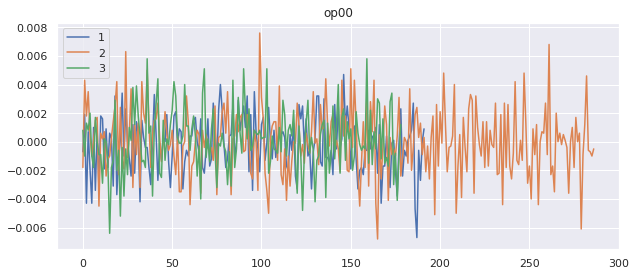

<Figure size 432x288 with 0 Axes>

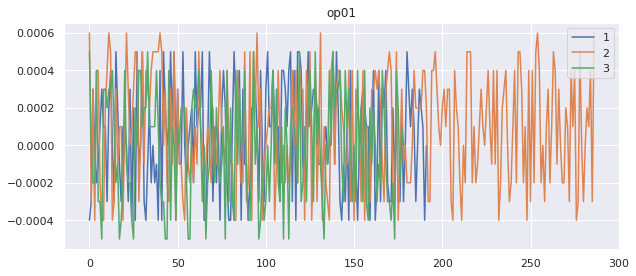

<Figure size 432x288 with 0 Axes>

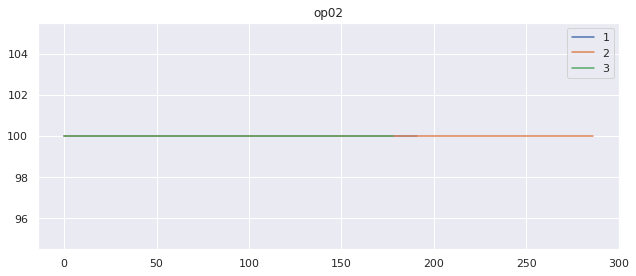

<Figure size 432x288 with 0 Axes>

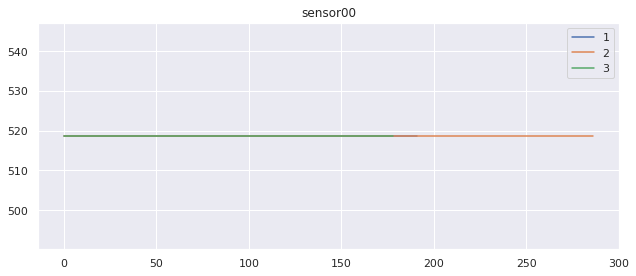

<Figure size 432x288 with 0 Axes>

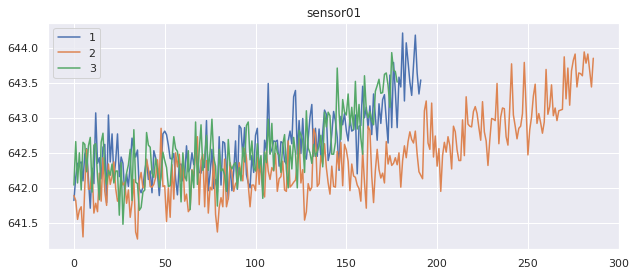

<Figure size 432x288 with 0 Axes>

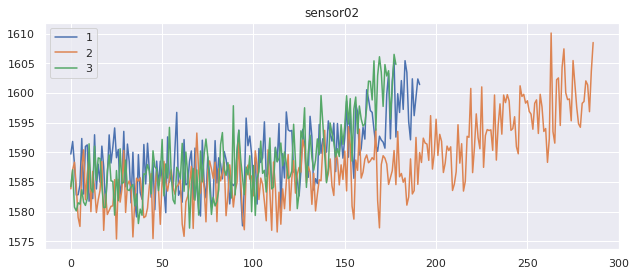

<Figure size 432x288 with 0 Axes>

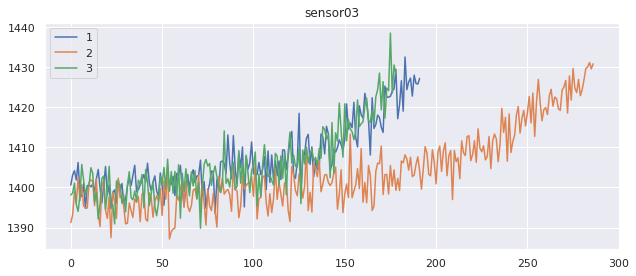

<Figure size 432x288 with 0 Axes>

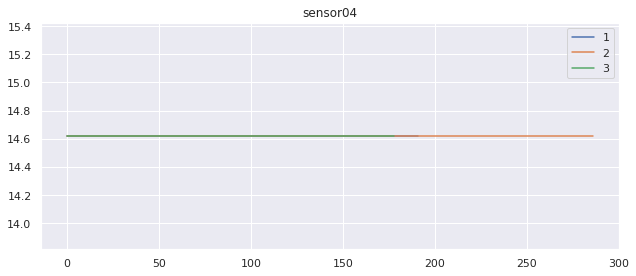

<Figure size 432x288 with 0 Axes>

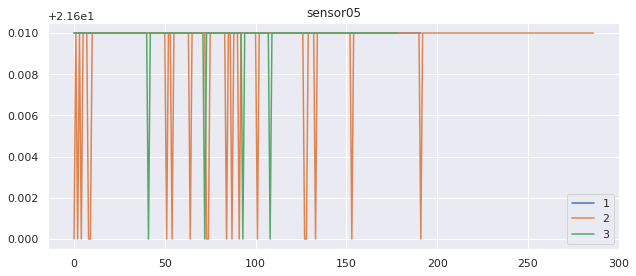

<Figure size 432x288 with 0 Axes>

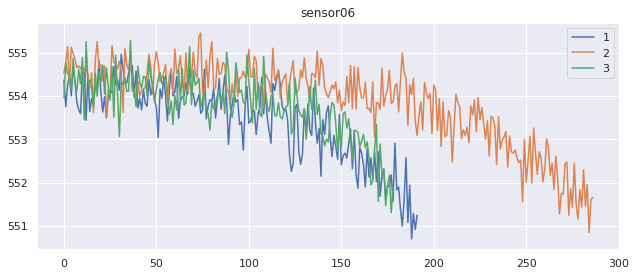

<Figure size 432x288 with 0 Axes>

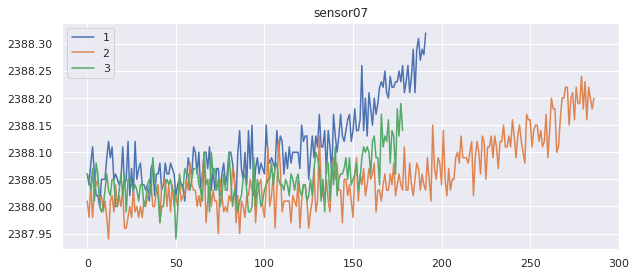

<Figure size 432x288 with 0 Axes>

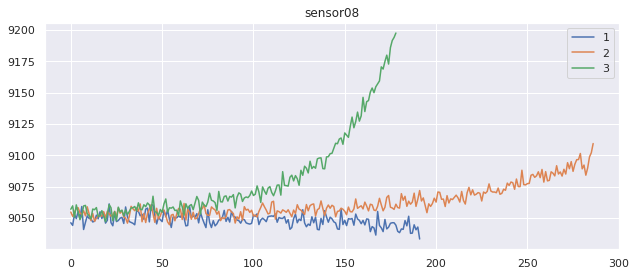

<Figure size 432x288 with 0 Axes>

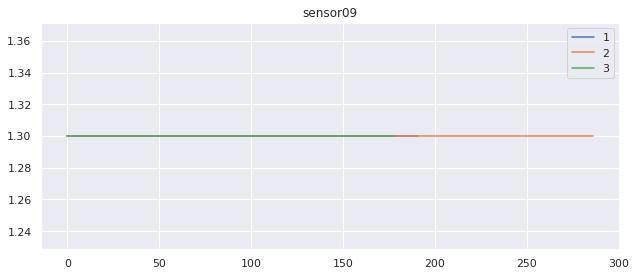

<Figure size 432x288 with 0 Axes>

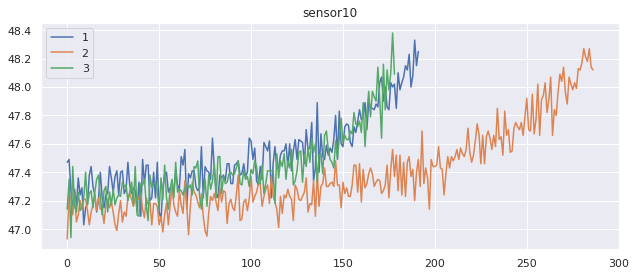

<Figure size 432x288 with 0 Axes>

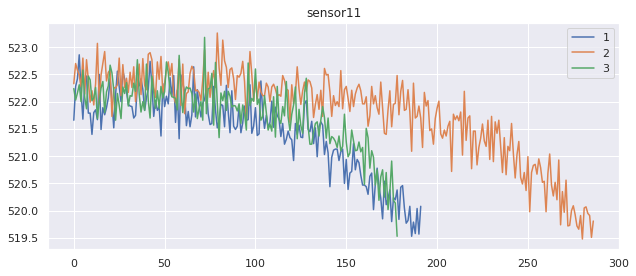

<Figure size 432x288 with 0 Axes>

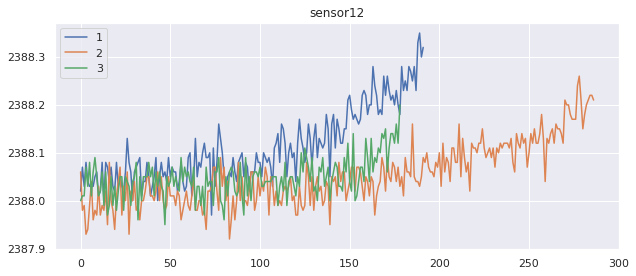

<Figure size 432x288 with 0 Axes>

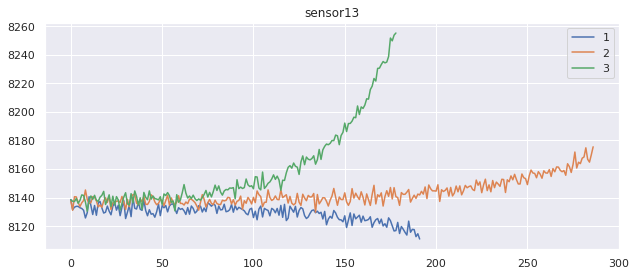

<Figure size 432x288 with 0 Axes>

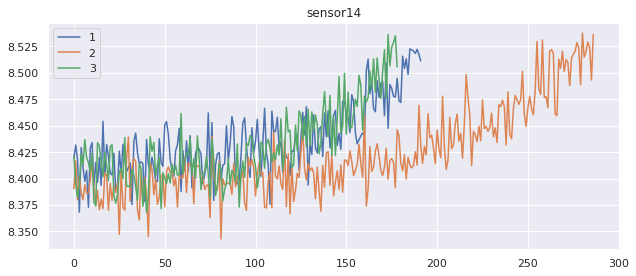

<Figure size 432x288 with 0 Axes>

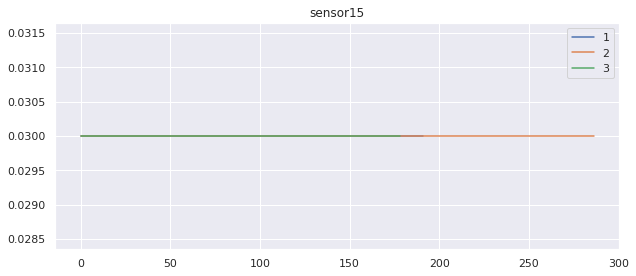

<Figure size 432x288 with 0 Axes>

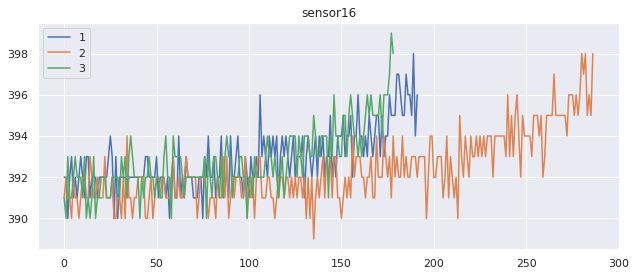

<Figure size 432x288 with 0 Axes>

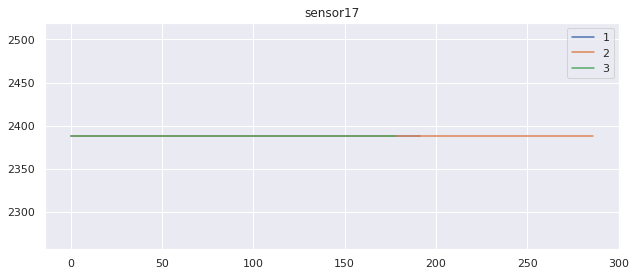

<Figure size 432x288 with 0 Axes>

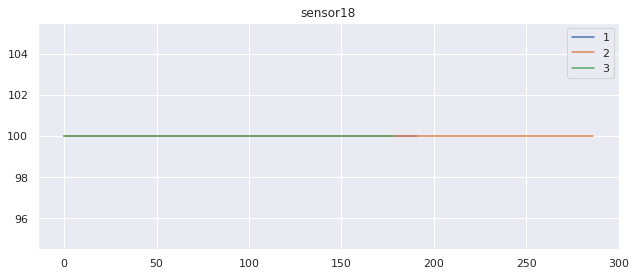

<Figure size 432x288 with 0 Axes>

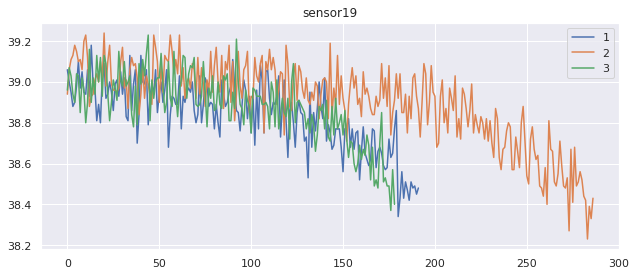

<Figure size 432x288 with 0 Axes>

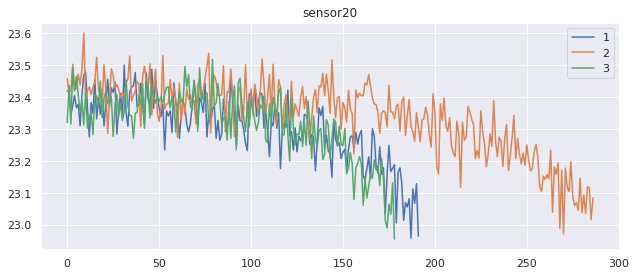

<Figure size 432x288 with 0 Axes>

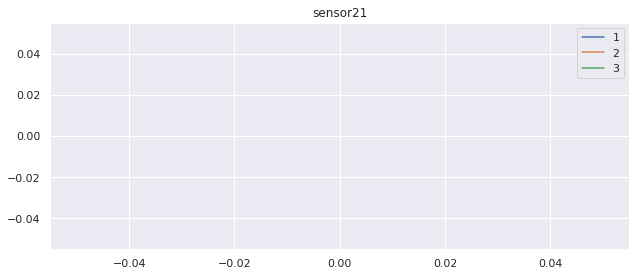

<Figure size 432x288 with 0 Axes>

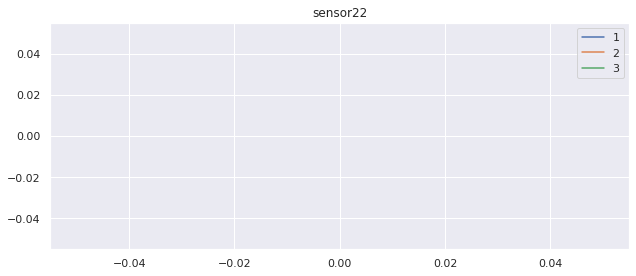

<Figure size 432x288 with 0 Axes>

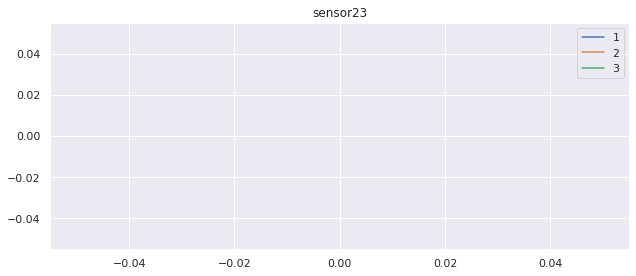

<Figure size 432x288 with 0 Axes>

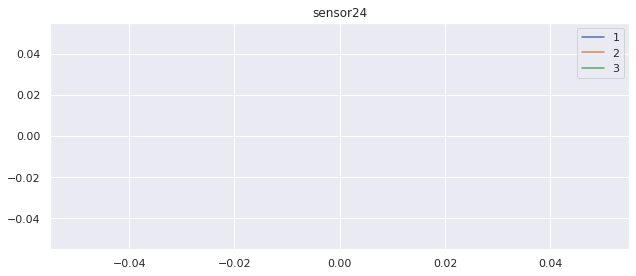

<Figure size 432x288 with 0 Axes>

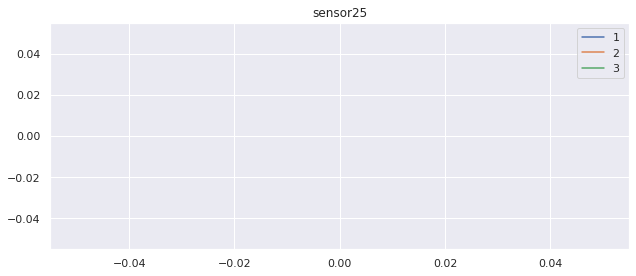

<Figure size 432x288 with 0 Axes>

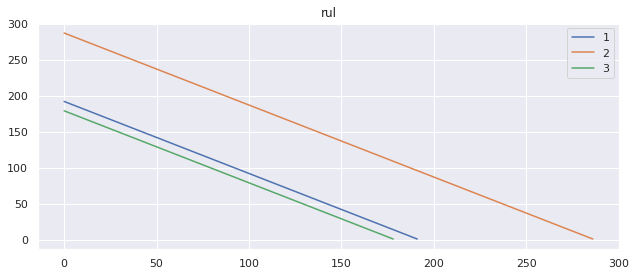

<Figure size 432x288 with 0 Axes>

In [17]:
def show_signal(df: pd.DataFrame, units: Sequence[int]) -> None:
    """一部の信号を可視化."""
    for name in df.columns:
        fig, axes = plt.subplots(1, 1, figsize=(9, 4), tight_layout=True)
        ax = axes
        for unit in units:
            ax.plot(df.loc[unit, name], label=unit)
        ax.set_title(name)
        ax.legend()
        plt.show()
        plt.clf()
        fig.clf()


show_signal(DF_FD001_TRAIN, [1, 2, 3])

# Signal stats

## Signal length

INFO:__main__:min length: 128, max length: 362


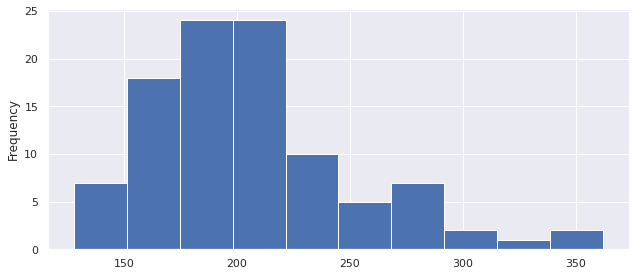

In [18]:
def show_signal_length(df: pd.DataFrame) -> None:
    """信号長のヒストグラムを表示."""
    ser = df.iloc[:, 0]
    ser_length = ser.apply(lambda x: x.shape[0])

    _logger.info(f"min length: {ser_length.min()}, max length: {ser_length.max()}")

    fig, axes = plt.subplots(1, 1, figsize=(9, 4), tight_layout=True)
    ax = axes
    ser_length.plot.hist(ax=ax)
    plt.show()
    plt.close()
    fig.clf()


show_signal_length(DF_FD001_TRAIN)

## Unique values

ユニーク数が1であるため、有効な変数となっていない。

- op02
- sensor01
- sensor04
- sensor09
- sensor15
- sensor17
- sensor18

全てnanなので有効な変数ではない。

- sensor21 ~ 25

ユニーク数が少ないため、内容を確認したが、とりあえずはそのまま利用できそう。

- op01: 浮動小数点で構成されており、1unit10パターンぐらい含まれているので、カテゴリ変数ではなく、かつ普通に変動する変数のよう。ただ、値の取り方が離散的で、特定範囲に収まっている?
- sensor05: 2値しか取らない。信号グラフを見る限り、突発的に値が変動する時があるというように見える。
- sensor07: 値が少々離散的だが、カテゴリ変数ではなく、データがとる値の数が少ないと言うだけのようです。
- sensor12: sensor07と同様の傾向です。
- sensor16: 整数で構成されているのでカテゴリ変数の可能性を排除できないが、値は大きめなので離散的な値しか取得できないセンサ?

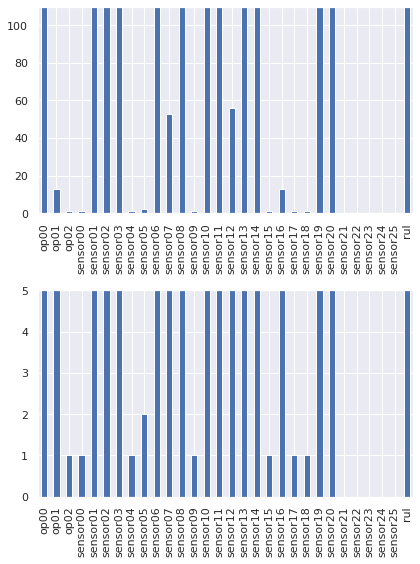

In [19]:
def show_nunique(df: pd.DataFrame) -> None:
    """ユニーク数の確認."""
    df_unique = df.applymap(lambda x: np.unique(x))
    df_unique = df_unique.apply(lambda x: np.hstack(x.ravel()), axis=0)
    df_unique = df_unique.apply(lambda x: len(np.unique(x[~np.isnan(x)])))

    fig, axes = plt.subplots(2, 1, figsize=(6, 8), tight_layout=True)
    ax = axes[0]
    df_unique.plot.bar(ax=ax)
    ax.set_ylim((0, 110))
    ax = axes[1]
    df_unique.plot.bar(ax=ax)
    ax.set_ylim((0, 5))
    plt.show()
    plt.close()
    fig.clf()


show_nunique(DF_FD001_TRAIN)

In [20]:
def show_unique_unit(series: pd.Series) -> None:
    """unitごとにユニーク数を可視化."""
    ser_unique = series.apply(lambda x: len(np.unique(x)))

    fig, axes = plt.subplots(1, 1, figsize=(9, 3), tight_layout=True)
    ax = axes
    ser_unique.plot.bar(ax=ax)
    ax.set_title(series.name)
    plt.show()
    plt.close()
    fig.clf()

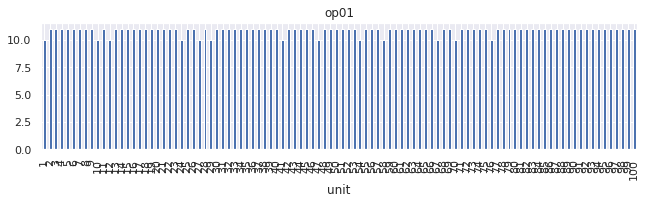

In [21]:
show_unique_unit(DF_FD001_TRAIN["op01"])

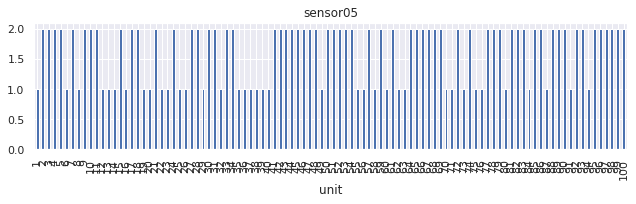

In [22]:
show_unique_unit(DF_FD001_TRAIN["sensor05"])

In [23]:
def show_unique_value(series: pd.Series) -> None:
    ser_unique = series.apply(lambda x: np.unique(x))
    all_unique = np.unique(np.hstack(ser_unique))
    _logger.info(f"unique values: {all_unique}")

In [24]:
show_unique_value(DF_FD001_TRAIN["sensor05"])

INFO:__main__:unique values: [21.6  21.61]


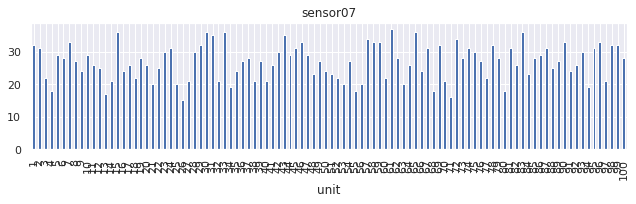

In [25]:
show_unique_unit(DF_FD001_TRAIN["sensor07"])

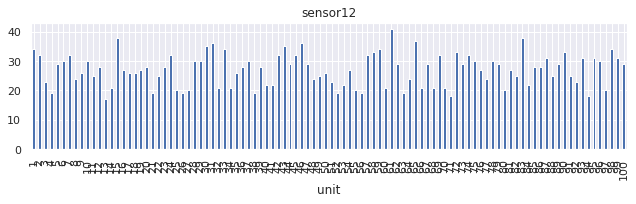

In [26]:
show_unique_unit(DF_FD001_TRAIN["sensor12"])

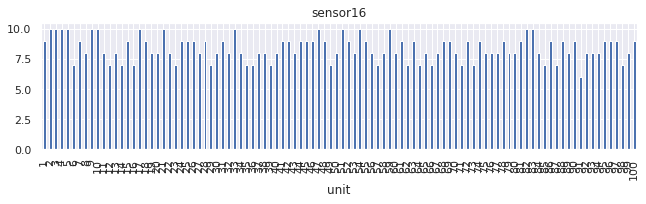

In [27]:
show_unique_unit(DF_FD001_TRAIN["sensor16"])